In [185]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [186]:
np.random.seed(42)
tf.random.set_seed(42)

In [187]:
height= 224
width= 224
batch_size= 32

In [188]:
train_dir = 'car_data/train'
test_dir = 'car_data/test'

In [189]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

In [190]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= (height, width),
    batch_size= batch_size,
    class_mode= 'categorical',
    shuffle=True,
)

Found 8144 images belonging to 196 classes.


In [191]:
test_generator= test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size= batch_size,
    class_mode='categorical',
    shuffle=False,
)

Found 8041 images belonging to 196 classes.


In [192]:
train_generator.class_indices

{'AM General Hummer SUV 2000': 0,
 'Acura Integra Type R 2001': 1,
 'Acura RL Sedan 2012': 2,
 'Acura TL Sedan 2012': 3,
 'Acura TL Type-S 2008': 4,
 'Acura TSX Sedan 2012': 5,
 'Acura ZDX Hatchback 2012': 6,
 'Aston Martin V8 Vantage Convertible 2012': 7,
 'Aston Martin V8 Vantage Coupe 2012': 8,
 'Aston Martin Virage Convertible 2012': 9,
 'Aston Martin Virage Coupe 2012': 10,
 'Audi 100 Sedan 1994': 11,
 'Audi 100 Wagon 1994': 12,
 'Audi A5 Coupe 2012': 13,
 'Audi R8 Coupe 2012': 14,
 'Audi RS 4 Convertible 2008': 15,
 'Audi S4 Sedan 2007': 16,
 'Audi S4 Sedan 2012': 17,
 'Audi S5 Convertible 2012': 18,
 'Audi S5 Coupe 2012': 19,
 'Audi S6 Sedan 2011': 20,
 'Audi TT Hatchback 2011': 21,
 'Audi TT RS Coupe 2012': 22,
 'Audi TTS Coupe 2012': 23,
 'Audi V8 Sedan 1994': 24,
 'BMW 1 Series Convertible 2012': 25,
 'BMW 1 Series Coupe 2012': 26,
 'BMW 3 Series Sedan 2012': 27,
 'BMW 3 Series Wagon 2012': 28,
 'BMW 6 Series Convertible 2007': 29,
 'BMW ActiveHybrid 5 Sedan 2012': 30,
 'BMW 

In [193]:
images, labels = next(train_generator)

In [194]:
images.shape

(32, 224, 224, 3)

In [195]:
labels.shape

(32, 196)

In [196]:
def plot_images(images_arr, labels_arr):

    random.seed(23)

    images_labels = list(zip(images_arr, labels_arr))

    five_images = random.sample(images_labels, 5)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))

    class_names = list(train_generator.class_indices.keys())
    
    for ax, (img, lbl) in zip(axes, five_images):
        if isinstance(lbl, (list, np.ndarray)) and len(lbl) > 1:
            lbl = np.argmax(lbl)
            
        ax.imshow(img)
        ax.set_title(class_names[int(lbl)])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

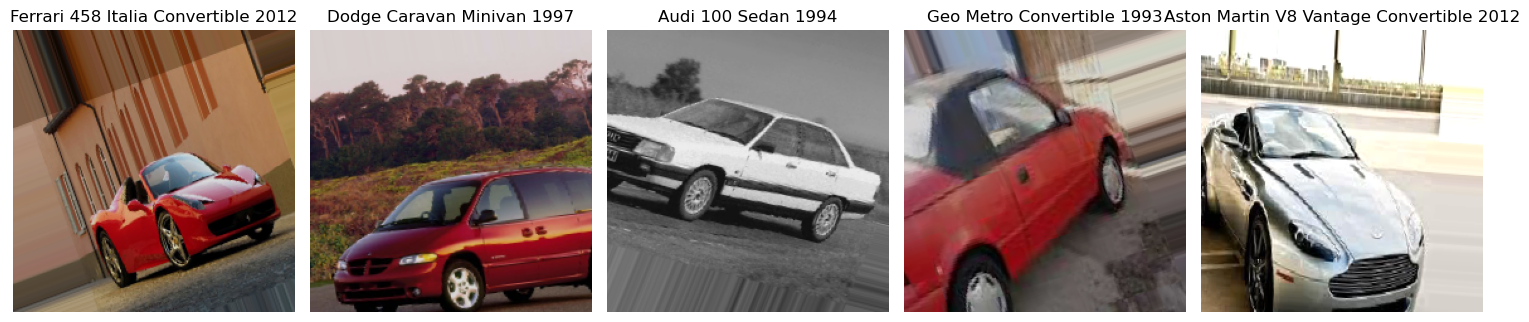

In [197]:
plot_images(images, labels)

In [198]:
num_classes = len(np.unique(train_generator.labels))
num_classes

196

In [199]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

# Residual Block
def residual_block(x, filters, kernel_size=3, stride=1, use_batch_norm=True):
   
    shortcut = x
    
    # First convolution
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation=None)(x)
    if use_batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', activation=None)(x)
    if use_batch_norm:
        x = layers.BatchNormalization()(x)

    # Add the shortcut connection
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

# ResNet Model
def build_resnet(input_shape, num_classes):
    
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Add residual blocks
    x = residual_block(x, filters=64, kernel_size=3)
    x = residual_block(x, filters=128, kernel_size=3, stride=2)
    x = residual_block(x, filters=256, kernel_size=3, stride=2)
    x = residual_block(x, filters=512, kernel_size=3, stride=2)

    # Global Average Pooling and Output
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Define input shape and number of classes
input_shape = (height, width, 3)
num_classes = train_generator.num_classes

# Build and compile the model
resnet_model = build_resnet(input_shape, num_classes)
resnet_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Model summary
resnet_model.summary()


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_132 (Conv2D)            (None, 112, 112, 64  9472        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_98 (BatchN  (None, 112, 112, 64  256        ['conv2d_132[0][0]']             
 ormalization)                  )                                                          

In [200]:
checkpoint = ModelCheckpoint('best_weights.keras', monitor='val_accuracy', save_best_only=True, mode='max')

In [201]:
# Train the model
history = resnet_model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[checkpoint]
)

Epoch 1/30
255/255 [==============================] - 187s 733ms/step - loss: 5.2767 - accuracy: 0.0074 - val_loss: 5.2321 - val_accuracy: 0.0087
Epoch 2/30
255/255 [==============================] - 184s 724ms/step - loss: 5.1585 - accuracy: 0.0140 - val_loss: 8.2289 - val_accuracy: 0.0078
Epoch 3/30
255/255 [==============================] - 195s 766ms/step - loss: 5.0926 - accuracy: 0.0179 - val_loss: 5.2990 - val_accuracy: 0.0136
Epoch 4/30
255/255 [==============================] - 190s 745ms/step - loss: 5.0189 - accuracy: 0.0246 - val_loss: 5.0963 - val_accuracy: 0.0198
Epoch 5/30
255/255 [==============================] - 185s 726ms/step - loss: 4.9383 - accuracy: 0.0327 - val_loss: 5.2372 - val_accuracy: 0.0215
Epoch 6/30
255/255 [==============================] - 182s 717ms/step - loss: 4.8654 - accuracy: 0.0372 - val_loss: 5.5548 - val_accuracy: 0.0203
Epoch 7/30
255/255 [==============================] - 184s 721ms/step - loss: 4.7781 - accuracy: 0.0462 - val_loss: 5.2651 -

In [202]:
# Evaluate the model
loss, accuracy = resnet_model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

252/252 [==============================] - 90s 358ms/step - loss: 2.4951 - accuracy: 0.4358
Test Accuracy: 43.58%


In [203]:
def plot_learning_curve(history, metrics):
    acc = history.history[metrics]
    val_acc = history.history[f'val_{metrics}']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(5,3))
    plt.plot(epochs, acc, label=f'training {metrics}')
    plt.plot(epochs, val_acc, label=f'validation {metrics}')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.legend()

    plt.figure(figsize=(5,3))
    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

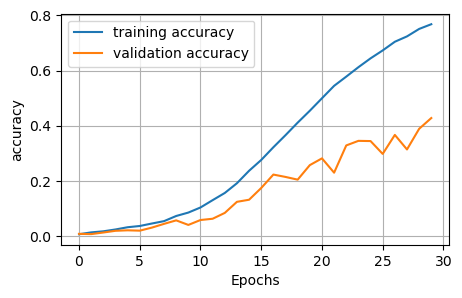

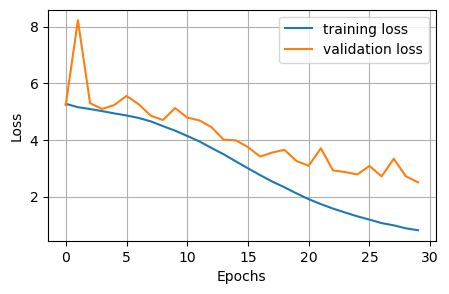

In [204]:
plot_learning_curve(history, metrics='accuracy')

In [205]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [217]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('best_weights.keras')

In [219]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def prediction(image_path, model, class_indices, target_size=(height, width)):

    # Preprocess the image
    def preprocess_image(image_path, target_size=(height, width)):
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        return np.expand_dims(img_array, axis=0)

    # Preprocess the input image
    preprocessed_image = preprocess_image(image_path, target_size)

    # Make prediction
    predictions = model.predict(preprocessed_image)
    predicted_label = np.argmax(predictions, axis=1)[0]

    # Map the predicted label to the class name
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[predicted_label]

    # Display the image with the prediction
    img = load_img(image_path, target_size=target_size)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

1/1 [==============================] - 0s 130ms/step


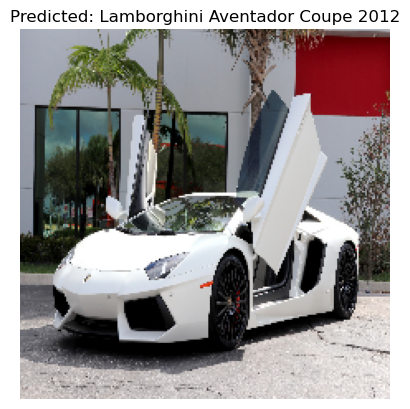

The predicted class is: Lamborghini Aventador Coupe 2012


In [220]:
# Call the function
image_path = "C:\\Users\\medoo\\OneDrive\\Desktop\\Used-2012-Lamborghini-Aventador-LP-700-4.jpg"
predicted_class = prediction(image_path, model, train_generator.class_indices)

print(f"The predicted class is: {predicted_class}")